In [115]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns
from numpy import median
from yellowbrick.regressor import ResidualsPlot

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ridge_regression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler

## Data reading & munging
Identify columns with missing values, discard features with significant missing values; Impute values for the rest.

### Read datset. Identifying na records & handling
Data is read. Dataset is analyzed for null values. Features with significant (i.e more than 30%) null values are discarded as imputation may result in distortion. For other features, missing values are imputed. 

In [2]:
data = pd.read_csv(r"C:\Users\HP\Documents\DataScience\Python Scripts\Iowa Housing\train1.csv")

Col_NA = {}
Cols = data.columns
for col in Cols:
    na_count = data[col].isnull().sum()
    Col_NA[col] = na_count

Col_Drop =[]

for key, value in Col_NA.items():
    val = value/data[key].count()
    if val > 0.3:
        key = str(key)
        Col_Drop.append(key)  

print("Features with significant missing values are: {}".format(Col_Drop))
        
Col_fill =[]
for key, value in Col_NA.items():
    val = value/data[key].count()
    if val < 0.3:
        if val > 0:
            Col_fill.append(key)

print("Features with missing values to be filled are: {}".format(Col_fill))

data1 = data
for col_d in Col_Drop:
    del data1[col_d]

data2 = data1.apply(lambda x:x.fillna(x.value_counts().index[0]))

Features with significant missing values are: ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Features with missing values to be filled are: ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


## A look at the Data!

### Statistical - Central tendency, Dispersion, Correlation, Multicollinearity

In [3]:
data2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [4]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

In [5]:
data2.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,67.404110,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,23.773024,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Analyze correlation 
#### Between features and target: 
Target & numeric features - Pearson coeff
Between features and categorical features - ANOVA



In [6]:
num_Col = []
for col in data2.columns:
    if data2[col].dtype != 'O':
        num_Col.append(col)
data_num = data2[num_Col]
corr_df = pd.DataFrame()
corr_df = data_num.corr()
corr_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,0.045302,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.318503,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,0.045302,-0.318503,1.000000,0.261947,0.227885,-0.062296,0.098942,0.091102,0.160471,0.186872,...,0.044841,0.113682,0.005598,0.050934,0.033352,0.169887,-0.016133,0.013789,-0.012619,0.315862
LotArea,-0.033226,-0.139781,0.261947,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.227885,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.062296,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.098942,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.091102,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.051071,0.023573,0.160471,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.005024,-0.069836,0.186872,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


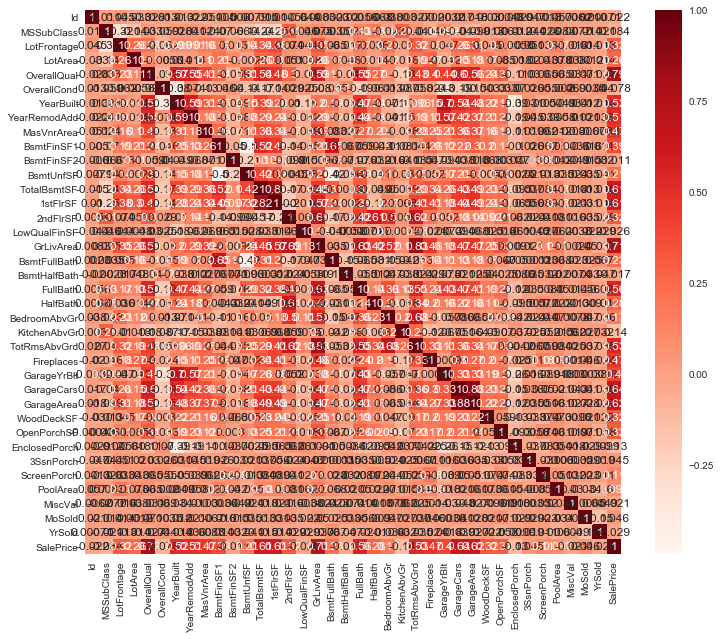

In [136]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_df, annot=True, cmap=plt.cm.Reds)
plt.show()

## Feature Engineering

### Identify & Handle MultiCollinearity
### Handle Qualitative features - Encoding 
Note: Feature selection (Wrapper, Embedded) techniques not used in this project due to the dimensionality and also because model fit was found to be excellent even without this step. 

###  Handling Multicollinearity 

#### Handling Multicollinearity - Detection
Using Corr matrix and VIF ANALYSIS: By systematically analyzing the corr matrix, we can see that there are 6 feature-pairs that have high correlation i.e above 0.7. VIF computation is done and it shows few features with excessive vif including few with infinite. Hence it is clear that multicolliearity exists. 

In [7]:
colnames = list(data_num)
features = colnames
features.remove('SalePrice')
X = data_num[features]
MulCol = {}
for roww in colnames:
    for col in colnames:
        if roww != col:
            if corr_df.ix[roww, col] > 0.7:
                if roww not in MulCol:
                    MulCol[roww] = col
                elif type(MulCol[roww]) == list:
                    MulCol[roww].append(col)
                else:
                    MulCol[roww] = [MulCol[roww], col]

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


Bring out feature pairs that have very high pearson correlation coefficient. This is useful to identify candidates for dropping based on VIF values.

In [9]:
MulCol

{'1stFlrSF': 'TotalBsmtSF',
 'GarageArea': 'GarageCars',
 'GarageCars': 'GarageArea',
 'GarageYrBlt': 'YearBuilt',
 'GrLivArea': 'TotRmsAbvGrd',
 'TotRmsAbvGrd': 'GrLivArea',
 'TotalBsmtSF': '1stFlrSF',
 'YearBuilt': 'GarageYrBlt'}

Compute & display VIF

In [10]:
variables = list(X.columns)
vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
vif

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'1stFlrSF': inf,
 '2ndFlrSF': inf,
 '3SsnPorch': 1.0383703183931212,
 'BedroomAbvGr': 31.028625345546875,
 'BsmtFinSF1': inf,
 'BsmtFinSF2': inf,
 'BsmtFullBath': 3.6973531361984833,
 'BsmtHalfBath': 1.2190112334463494,
 'BsmtUnfSF': inf,
 'EnclosedPorch': 1.4459859757410696,
 'Fireplaces': 3.0185078911457301,
 'FullBath': 26.710275433240476,
 'GarageArea': 31.511300624734915,
 'GarageCars': 37.63982074521757,
 'GarageYrBlt': 16128.572687780648,
 'GrLivArea': inf,
 'HalfBath': 3.4218001583617328,
 'Id': 4.1205006195707163,
 'KitchenAbvGr': 37.599006969673717,
 'LotArea': 2.6283349540353149,
 'LotFrontage': 13.15732039763453,
 'LowQualFinSF': inf,
 'MSSubClass': 4.5319507527647271,
 'MasVnrArea': 1.8489953796713456,
 'MiscVal': 1.0320936076704197,
 'MoSold': 6.6489894919406449,
 'OpenPorchSF': 1.8281104552888736,
 'OverallCond': 41.912355577498246,
 'OverallQual': 66.743705752417398,
 'PoolArea': 1.1083816982522376,
 'ScreenPorch': 1.1907014184029123,
 'TotRmsAbvGrd': 83.59107884542531

#### Handling multicollienarity - Feature Removal - Iteration # 1
Based on above VIF and corr pairs, some features (1stFlrSF, GarageCars, GarageYrBlt and TotRmsAbvGrd) are removed. Further VIF is computed. 

In [11]:
features1 = features
MulCol_Feat_Rm1 = ['1stFlrSF', 'GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd']
for col in MulCol_Feat_Rm1:
    features1.remove(col)
features1

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [12]:
data_num1 = data_num[features1]
colnames1 = list(data_num1)
corr_df1 = data_num1.corr()
MulCol1 = {}
for roww in colnames1:
    for col in colnames1:
        if roww != col:
            if corr_df1.ix[roww, col] > 0.6:
                if roww not in MulCol1:
                    MulCol1[roww] = col
                elif type(MulCol1[roww]) == list:
                    MulCol1[roww].append(col)
                else:
                    MulCol1[roww] = [MulCol1[roww], col]
MulCol1

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


{'2ndFlrSF': ['GrLivArea', 'HalfBath'],
 'BsmtFinSF1': 'BsmtFullBath',
 'BsmtFullBath': 'BsmtFinSF1',
 'FullBath': 'GrLivArea',
 'GrLivArea': ['2ndFlrSF', 'FullBath'],
 'HalfBath': '2ndFlrSF'}

In [13]:
X = data_num[features1]
variables = list(X.columns)
vif1 = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
vif1

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'2ndFlrSF': 10.723571008090232,
 '3SsnPorch': 1.0375462748183399,
 'BedroomAbvGr': 24.738855786652891,
 'BsmtFinSF1': inf,
 'BsmtFinSF2': inf,
 'BsmtFullBath': 3.6931696088836707,
 'BsmtHalfBath': 1.2163571278860257,
 'BsmtUnfSF': inf,
 'EnclosedPorch': 1.4417076111543239,
 'Fireplaces': 2.944185819450797,
 'FullBath': 26.191446605423788,
 'GarageArea': 11.031829792501171,
 'GrLivArea': 87.098264899521709,
 'HalfBath': 3.4026065539463066,
 'Id': 4.1117965962620886,
 'KitchenAbvGr': 34.810265523675604,
 'LotArea': 2.6236633986025644,
 'LotFrontage': 13.136800161451253,
 'LowQualFinSF': 1.1784819729934799,
 'MSSubClass': 4.4788461127707819,
 'MasVnrArea': 1.847717702633523,
 'MiscVal': 1.0286589944818387,
 'MoSold': 6.6328744498277494,
 'OpenPorchSF': 1.8080140108792138,
 'OverallCond': 40.778238335121856,
 'OverallQual': 65.353793212325968,
 'PoolArea': 1.0970952693944207,
 'ScreenPorch': 1.1879778441061075,
 'TotalBsmtSF': inf,
 'WoodDeckSF': 1.8980745597399209,
 'YearBuilt': 17100.36

#### Handling MultiCollinearity - Feature Removal - Iteration # 2 
Based on above VIF and corr pairs, some features ('HalfBath', '2ndFlrSF', 'BsmtFullBath', 'FullBath') are removed. Further another round of corr & VIF computation is done.Interestinlgy, some features with inf vif do not have high corr values.  

In [14]:
features2 = features1
MulCol_Feat_Rm2 = ['HalfBath', '2ndFlrSF', 'BsmtFullBath', 'FullBath']
for col in MulCol_Feat_Rm2:
    features2.remove(col)
features2

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [15]:
# Mulcol after 2nd round of feature removal:
data_num2 = data_num[features2]
colnames2 = list(data_num2)
corr_df2 = data_num2.corr()
MulCol2 = {}
for roww in colnames2:
    for col in colnames2:
        if roww != col:
            if corr_df2.ix[roww, col] > 0.6:
                if roww not in MulCol2:
                    MulCol2[roww] = col
                elif type(MulCol2[roww]) == list:
                    MulCol2[roww].append(col)
                else:
                    MulCol2[roww] = [MulCol2[roww], col]
MulCol2

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


{}

In [16]:
X = data_num[features2]
variables = list(X.columns)
vif2 = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
vif2

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'3SsnPorch': 1.0339575371241378,
 'BedroomAbvGr': 23.544160671875652,
 'BsmtFinSF1': inf,
 'BsmtFinSF2': inf,
 'BsmtHalfBath': 1.1068955985733144,
 'BsmtUnfSF': inf,
 'EnclosedPorch': 1.433964694116769,
 'Fireplaces': 2.8625266131601417,
 'GarageArea': 10.944308056466733,
 'GrLivArea': 34.860897884596739,
 'Id': 4.0996254953954656,
 'KitchenAbvGr': 31.692237170054177,
 'LotArea': 2.6039476294098569,
 'LotFrontage': 13.048800400830775,
 'LowQualFinSF': 1.1230419248909571,
 'MSSubClass': 4.1808156883812764,
 'MasVnrArea': 1.8343617994866772,
 'MiscVal': 1.0249673082167137,
 'MoSold': 6.617346703384098,
 'OpenPorchSF': 1.7833114401742818,
 'OverallCond': 40.573395604659112,
 'OverallQual': 64.589708283661523,
 'PoolArea': 1.0923316456720567,
 'ScreenPorch': 1.1838066161587146,
 'TotalBsmtSF': inf,
 'WoodDeckSF': 1.8860520111143384,
 'YearBuilt': 14521.261112156337,
 'YearRemodAdd': 20029.809724192673,
 'YrSold': 17346.179183824963}

In [19]:
for key, val in vif2.items():
    if vif2[key] > 5:
        print(key)
        print(vif2[key])
        print()

LotFrontage
13.0488004008

OverallQual
64.5897082837

OverallCond
40.5733956047

YearBuilt
14521.2611122

YearRemodAdd
20029.8097242

BsmtFinSF1
inf

BsmtFinSF2
inf

BsmtUnfSF
inf

TotalBsmtSF
inf

GrLivArea
34.8608978846

BedroomAbvGr
23.5441606719

KitchenAbvGr
31.6922371701

GarageArea
10.9443080565

MoSold
6.61734670338

YrSold
17346.1791838



#### Handling Multicollinearity - Feature removal  - Iteration # 3
Based on above VIF and corr pairs, some features ('BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'OverallQual') are removed. Further another round of corr & VIF computation is done.Interestinlgy, some features still have high vif (>10) but do not have high corr values.  But, due to lack of data dictonary, further removal of features is difficult. Hence for purposes of this run, these features are retained.

In [17]:
# 3rd round of feature removal:
features3 = features2
MulCol_Feat_Rm2 = ['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'OverallQual']
for col in MulCol_Feat_Rm2:
    features3.remove(col)
features3

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtUnfSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [18]:
# Mulcol after 3rd round of feature removal:
data_num3 = data_num[features3]
colnames3 = list(data_num3)
corr_df3 = data_num3.corr()
MulCol3 = {}
for roww in colnames3:
    for col in colnames3:
        if roww != col:
            if corr_df3.ix[roww, col] > 0.6:
                if roww not in MulCol3:
                    MulCol3[roww] = col
                elif type(MulCol3[roww]) == list:
                    MulCol3[roww].append(col)
                else:
                    MulCol3[roww] = [MulCol3[roww], col]
MulCol3

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


{}

In [19]:
X = data_num[features3]
variables = list(X.columns)
vif3 = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
vif3

{'3SsnPorch': 1.0330462370261646,
 'BedroomAbvGr': 22.079163252113347,
 'BsmtHalfBath': 1.1001056825447109,
 'BsmtUnfSF': 3.1258993868584808,
 'EnclosedPorch': 1.4152998826164678,
 'Fireplaces': 2.7892872180901573,
 'GarageArea': 10.603306240778371,
 'GrLivArea': 29.589786056909176,
 'Id': 4.0933605644741462,
 'KitchenAbvGr': 30.353240269262422,
 'LotArea': 2.5309354147324101,
 'LotFrontage': 12.931115647954829,
 'LowQualFinSF': 1.1227072647078638,
 'MSSubClass': 3.895018369926996,
 'MasVnrArea': 1.7736849308857361,
 'MiscVal': 1.024728013492721,
 'MoSold': 6.5793039211889894,
 'OpenPorchSF': 1.7750468932649637,
 'OverallCond': 39.725251434373504,
 'PoolArea': 1.0819477740933634,
 'ScreenPorch': 1.1715374713696345,
 'WoodDeckSF': 1.8660846852710851,
 'YearBuilt': 12803.778954174688,
 'YearRemodAdd': 19544.317242041798,
 'YrSold': 14422.77848990255}

### Handling Qualitative Features

#### Identify nominal & ordinal qualitative features.

This step is needed as Ordinal features can be encoded using Label encoding. Nominal features will need One Hot Encoding. 
Basis below anlaysis, all the qualtiative features seem nominal. Hence, OHE needs to be applied. 


In [49]:
Cat_Col = []
for col in data2.columns:
    if data2[col].dtype == 'O':
        Cat_Col.append(col)
data_Cat = data2[Cat_Col]

In [52]:
LOV =[]
Cat_Col_Val = {}
for col in data_Cat.columns:
    LOV = list(data_Cat[col].unique())
    Cat_Col_Val[col] = LOV      

In [53]:
Cat_Col_Val

{'BldgType': ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'],
 'BsmtCond': ['TA', 'Gd', 'Fa', 'Po'],
 'BsmtExposure': ['No', 'Gd', 'Mn', 'Av'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'BsmtQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'CentralAir': ['Y', 'N'],
 'Condition1': ['Norm',
  'Feedr',
  'PosN',
  'Artery',
  'RRAe',
  'RRNn',
  'RRAn',
  'PosA',
  'RRNe'],
 'Condition2': ['Norm',
  'Artery',
  'RRNn',
  'Feedr',
  'PosN',
  'PosA',
  'RRAn',
  'RRAe'],
 'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'Exterior1st': ['VinylSd',
  'MetalSd',
  'Wd Sdng',
  'HdBoard',
  'BrkFace',
  'WdShing',
  'CemntBd',
  'Plywood',
  'AsbShng',
  'Stucco',
  'BrkComm',
  'AsphShn',
  'Stone',
  'ImStucc',
  'CBlock'],
 'Exterior2nd': ['VinylSd',
  'MetalSd',
  'Wd Shng',
  'HdBoard',
  'Plywood',
  'Wd Sdng',
  'CmentBd',
  '

#### Feature Encoding
OHE is applied on all nominal features. 

In [56]:
data2_Dummies = pd.get_dummies(data_Cat, prefix=Cat_Col)
data3 = data2
data4 = data3.drop(Cat_Col, axis = 1)
data5 = data4.join(data2_Dummies)

## Modelling

### Linear Regression 

#### OLS as first attempt. 
Note: For OLS models, feature scaling is not needed. 

In [129]:
model = LinearRegression()

In [130]:
y = data5['SalePrice']
COLS = list(data5)
COLS.remove('SalePrice')
X = data5[COLS]

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 5)

In [132]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
tr_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print('Training Accuracy:', tr_accuracy)
print('Testing Accuracy:', test_accuracy)

Training Accuracy: 0.943140626283
Testing Accuracy: 0.832406458302


##### OLS Fit Analysis
Test Accuracy is about 83% which is good considering the data set size. 
Residual plot shows randomness - no patterns. Also we see uniform distribution of the residuals against the target in two dimensions. Hence, the Linear OLS model can be considered unbiased for this dataset. 

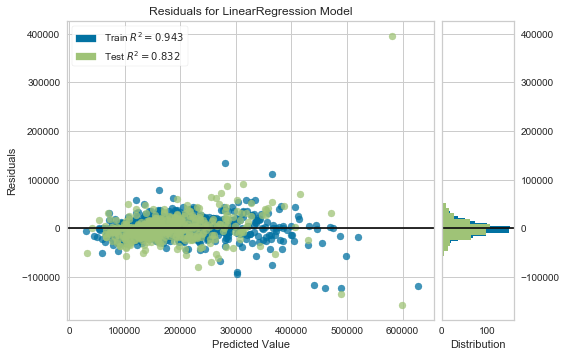

In [78]:
Lr = LinearRegression()
visualizer = ResidualsPlot(Lr)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

#### OLS Model Interpretation 
Intercept ('b') and Coefficients of the Linear OLS model can be found. Thus the equation y = MX + b where X is the feature vector can be formed - the same is to be used for interpretation. Coefficient of a feature gives a view of how much the 'Sale Price' will vary for every unit change in the given feature, other features remaining constant. However, following caveats apply:

1. OHE encoded features, care should be taken to understand that each of them is not a featuture but a feature-value.
2. As see above in 'Multicollinearity' section, there is still multicollinearity in the dataset and hence, the this interpreation may not be accurate, though the model accuracy is no impacted. 
3. Features have different scales, so relative importance of features should be not gauged based on absolute value of coefficients. 

In [113]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

In [84]:
coeff_df

,Coefficient
Id,-0.353011
MSSubClass,-130.862123
LotFrontage,76.356923
LotArea,0.763969
OverallQual,5999.079075
OverallCond,5732.232811
YearBuilt,335.999860
YearRemodAdd,71.221432
MasVnrArea,11.569668
BsmtFinSF1,17.903765


In [85]:
print(model.intercept_)

-1194334.86595


### Ridge Regression 
Ridge regression needs standardization of the data. Hence MinMaxScaler from Scikit-Learn is used. 
We can see that Testing accuracy has increased from 83% to 91% while Training accuracy has reduced from 94% to 91% - this shows that L2 regularization has given desired result. 

In [126]:
scaler = MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [127]:
X_s = scaler.transform(X)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

#### Ridge - Intrepretation
Similar to OLS, Intercept and Coefficients of the model can be brought out - the same can be seen below. However, unlike OLS since the data has been standardrized (in this case using MinMaxScaler), interpretation using absolute coeff values has no meaning. But interpretation of relative importance is useful. 

In [128]:
model_rr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_s, y)
print('Training Accuracy:', model_rr.score(X_train_s, y_train))
print('Testing Accuracy:', model_rr.score(X_test_s, y_test))
coeff_df_rr = pd.DataFrame(model_rr.coef_, X.columns, columns=['Coefficient'])
print(coeff_df_rr)
print(model_rr.intercept_)

Training Accuracy: 0.919698562453
Testing Accuracy: 0.90912913408
                        Coefficient
Id                      -411.213922
MSSubClass            -12337.512171
LotFrontage            -3626.332965
LotArea                64567.806823
OverallQual            64889.891678
OverallCond            35941.692144
YearBuilt              15722.485930
YearRemodAdd            5775.933879
MasVnrArea             28198.356742
BsmtFinSF1             37717.093943
BsmtFinSF2              9225.831078
BsmtUnfSF               2375.044802
TotalBsmtSF            37974.182960
1stFlrSF               79525.733300
2ndFlrSF               74303.784029
LowQualFinSF            3144.115005
GrLivArea              94538.224100
BsmtFullBath           14806.065359
BsmtHalfBath            1739.644429
FullBath               24476.282003
HalfBath                6049.044774
BedroomAbvGr          -15825.246141
KitchenAbvGr          -26712.404328
TotRmsAbvGrd           31954.343141
Fireplaces             13814.12046

### Other Models
Normally, other regression models such as Tree, SVM are tried out as extension of above models. But since we have got about 91% accuracy without bias (basis Residual plot) even with a small (1460 records) dataset, there is not much incentive in exploring other models in this case. 